In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
import malaya_speech
import numpy as np

2022-08-05 14:57:01.136141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/husein/tf-nvidia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from malaya_speech.train.model.vits import model
from malaya_speech.train.model import vits

In [5]:
hparams = vits.HParams(**malaya_speech.config.vits_base_config)
hparams

{'model': {'inter_channels': 192, 'hidden_channels': 192, 'filter_channels': 768, 'n_heads': 2, 'n_layers': 6, 'kernel_size': 3, 'p_dropout': 0.1, 'resblock': '1', 'resblock_kernel_sizes': [3, 7, 11], 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]], 'upsample_rates': [8, 8, 2, 2], 'upsample_initial_channel': 512, 'upsample_kernel_sizes': [16, 16, 4, 4], 'n_layers_q': 3, 'use_spectral_norm': False}, 'train': {'log_interval': 200, 'eval_interval': 1000, 'seed': 1234, 'epochs': 20000, 'learning_rate': 0.0002, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 64, 'fp16_run': True, 'lr_decay': 0.999875, 'segment_size': 8192, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45, 'c_kl': 1.0}, 'data': {'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 0}}

In [6]:
spec_channels = hparams.data.filter_length // 2 + 1
segment_size = hparams.train.segment_size // hparams.data.hop_length
spec_channels, segment_size

(513, 32)

In [7]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_rejected = '\'():;"'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [8]:
input_ids = tf.placeholder(tf.int32, [None, None], name = 'input_ids')
lens = tf.placeholder(tf.int32, [None], name = 'lens')
mel_outputs = tf.placeholder(tf.float32, [None, None, spec_channels])
mel_lengths = tf.placeholder(tf.int32, [None])

In [9]:
temperature = tf.placeholder(tf.float32, shape=(), name = 'temperature')
length_scale = tf.placeholder(tf.float32, shape=(), name = 'length_ratio')
noise_scale_w = tf.placeholder(tf.float32, shape=(), name = 'noise_scale_w')

In [10]:
model = vits.Model(len(MALAYA_SPEECH_SYMBOLS), spec_channels, segment_size, **hparams.model)


using StochasticDurationPredictor


In [11]:
y_hat, l_length, attn, ids_slice, x_mask, z_mask,\
      (z, z_p, m_p, logs_p, m_q, logs_q) = model(input_ids, lens, mel_outputs, mel_lengths)

In [12]:
outputs = model.infer(input_ids, lens, training = False, noise_scale = temperature,
                     length_scale = length_scale, noise_scale_w = noise_scale_w)
outputs

(<tf.Tensor 'generator/Tanh:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'ExpandDims:0' shape=(?, ?, 1) dtype=float32>,
 (<tf.Tensor 'residual_coupling_block/residual_coupling_layer/concat:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'add:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul_1:0' shape=(?, ?, 192) dtype=float32>))

In [13]:
from librosa.filters import mel as librosa_mel_fn

melbank = librosa_mel_fn(hparams.data.sampling_rate, hparams.data.filter_length, 
                          hparams.data.n_mel_channels,hparams.data.mel_fmin, hparams.data.mel_fmax)

MEL = tf.convert_to_tensor(melbank)

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return tf.log(tf.clip_by_value(x, clip_val, tf.reduce_max(x)) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return tf.exp(x) / C


def spectral_normalize(magnitudes):
    output = dynamic_range_compression(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression(magnitudes)
    return output

def spectrogram_tf(audio_norm, filter_length, hop_length):
    p = int((filter_length-hop_length)/2)
    padded = tf.pad(audio_norm, [[p, p]], mode ='reflect')
    spec = tf.abs(tf.signal.stft(
        padded,
        filter_length,
        hop_length,
        fft_length=None,
        window_fn=tf.signal.hann_window,
        pad_end=False,
    ))
    spec = tf.sqrt(spec ** 2 + 1e-6)
    return spec

def spec_to_mel(spec):
    spec = tf.matmul(spec, tf.transpose(MEL))
    spec = spectral_normalize(spec)
    return spec

/tmp/ipykernel_443533/600007807.py:3: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=None as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melbank = librosa_mel_fn(hparams.data.sampling_rate, hparams.data.filter_length,


In [14]:
f = spectrogram_tf(outputs[0][0,:,0], hparams.data.filter_length, hparams.data.hop_length)
y_hat_mel_out = spec_to_mel(f)

In [15]:
y_hat_mel_out = tf.identity(y_hat_mel_out, name = 'mel_output')
attn_out = tf.identity(outputs[1], name = 'alignment_histories')
y_hat = tf.identity(outputs[0][0,:,0], name = 'y_hat')

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

2022-08-05 14:57:31.068966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-05 14:57:31.073308: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-05 14:57:31.073652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2022-08-05 14:57:31.073661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2022-08-05 14:57:31.073733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-05 14:57:31.073760: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-05 14:57:31.073766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-05 14:57:31.085131: I tensorflow/core/platf

In [17]:
path = 'vits-yasmin-v3'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'vits-yasmin-v3/model.ckpt-200000'

In [18]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)


INFO:tensorflow:Restoring parameters from vits-yasmin-v3/model.ckpt-200000


In [19]:
import re
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    if string[-1] in '-,':
        string = string[:-1]
    if string[-1] not in '.,?!':
        string = string + '.'
    string = string.replace('&', ' dan ')
    string = string.replace(':', ',').replace(';', ',')
    if normalize:
        t = normalizer._tokenizer(string)
        for i in range(len(t)):
            if t[i] == '-':
                t[i] = ','
        string = ' '.join(t)
        string = normalizer.normalize(string, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = True)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = ''.join([c for c in string if c in MALAYA_SPEECH_SYMBOLS and c not in _rejected])
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [20]:
import matplotlib.pyplot as plt

In [21]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan ke arah organisasi atau industri yang berkaitan.')
t, ids

('haqkiem adalah pelajar tahun akhir yang mengambil ijazah sarjana muda sains komputer kecerdasan buatan utama dari universiti teknikal malaysia melaka utem yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam perisikan perisian dan pengaturcaraan ke arah organisasi atau industri yang berkaitan .',
 array([ 1, 47, 40, 56, 50, 48, 44, 52, 13, 40, 43, 40, 51, 40, 47, 13, 55,
        44, 51, 40, 49, 40, 57, 13, 59, 40, 47, 60, 53, 13, 40, 50, 47, 48,
        57, 13, 64, 40, 53, 46, 13, 52, 44, 53, 46, 40, 52, 41, 48, 51, 13,
        48, 49, 40, 65, 40, 47, 13, 58, 40, 57, 49, 40, 53, 40, 13, 52, 60,
        43, 40, 13, 58, 40, 48, 53, 58, 13, 50, 54, 52, 55, 60, 59, 44, 57,
        13, 50, 44, 42, 44, 57, 43, 40, 58, 40, 53, 13, 41, 60, 40, 59, 40,
        53, 13, 60, 59, 40, 52, 40, 13, 43, 40, 57, 48, 13, 60, 53, 48, 61,
        44, 57, 58, 48, 59, 48, 13, 59, 44, 50, 53, 48, 50, 40, 51, 13, 52,
        40, 51, 40, 64, 58, 48, 40, 

In [22]:
%%time

o = sess.run([y_hat, attn_out, y_hat_mel_out], feed_dict = {input_ids: [ids],
                                               lens: [len(ids)],
                                                temperature: 0.6666,
                                                           length_scale: 1.0,
                                                           noise_scale_w: 0.1})

2022-08-05 14:57:43.710862: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 64618496 exceeds 10% of system memory.
2022-08-05 14:57:43.710926: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 129236992 exceeds 10% of system memory.
2022-08-05 14:57:43.787872: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 64618496 exceeds 10% of system memory.
2022-08-05 14:57:43.799851: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 64618496 exceeds 10% of system memory.
2022-08-05 14:57:43.800007: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 64618496 exceeds 10% of system memory.


CPU times: user 31.5 s, sys: 3.74 s, total: 35.2 s
Wall time: 8.42 s


In [23]:
import IPython.display as ipd

ipd.Audio(o[0], rate = 22050)

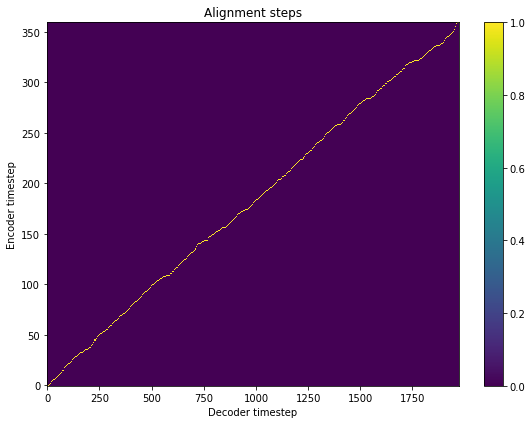

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[1][0].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

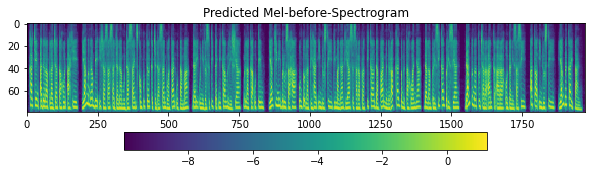

In [28]:
mel_outputs_ = np.reshape(o[-1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [29]:
saver = tf.train.Saver()
saver.save(sess, 'vits-yasmin-output-sdp/model.ckpt')

'vits-yasmin-output-sdp/model.ckpt'

In [30]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'input_ids' in n.name
        or 'lens' in n.name
        or 'temperature' in n.name
        or 'length_ratio' in n.name
        or 'noise_scale_w' in n.name
        or 'mel_output' in n.name
        or 'alignment_histories' in n.name
        or 'y_hat' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'AssignVariableOp' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['input_ids',
 'lens',
 'temperature',
 'length_ratio',
 'noise_scale_w',
 'Variable',
 'Variable_1',
 'Variable_2',
 'Variable_3',
 'Variable_4',
 'Variable_5',
 'Variable_6',
 'Variable_7',
 'Variable_8',
 'Variable_9',
 'Variable_10',
 'Variable_11',
 'Variable_12',
 'Variable_13',
 'Variable_14',
 'Variable_15',
 'model/text_encoder/embedding/embedding_lookup',
 'text_encoder/embedding/embedding_lookup',
 'mel_output',
 'alignment_histories',
 'y_hat']

In [31]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [32]:
freeze_graph('vits-yasmin-output-sdp', strings)



INFO:tensorflow:Restoring parameters from vits-yasmin-output-sdp/model.ckpt
INFO:tensorflow:Froze 570 variables.
INFO:tensorflow:Converted 570 variables to const ops.

11216 ops in the final graph.


In [33]:
import struct

unknown = b'\xff\xff\xff\xff'

def load_graph(frozen_graph_filename, return_def = False):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    for node in graph_def.node:
        if node.op == 'RefSwitch':
            node.op = 'Switch'
            for index in range(len(node.input)):
                if 'moving_' in node.input[index]:
                    node.input[index] = node.input[index] + '/read'
        elif node.op == 'AssignSub':
            node.op = 'Sub'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op == 'AssignAdd':
            node.op = 'Add'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op in ['Assign', 'AssignVariableOp']:
            if node.op == 'AssignVariableOp':
                node.attr.setdefault('T')
                node.attr['T'].type = node.attr['dtype'].type
                del node.attr['dtype']
            node.op = 'Identity'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
            if 'validate_shape' in node.attr:
                del node.attr['validate_shape']
            if len(node.input) == 2:
                node.input[0] = node.input[1]
                del node.input[1]
        elif node.op == 'Switch' and 'wave_net_block' in node.name and 'AssignVariableOp_' in node.name:
            node.attr['T'].type = 1
    
    if return_def:
        return graph_def
    
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [34]:
g = load_graph('vits-yasmin-output-sdp/frozen_model.pb')

In [35]:
test_sess = tf.InteractiveSession(graph = g)

In [36]:
input_nodes = ['input_ids', 'lens', 'temperature', 'length_ratio', 'noise_scale_w']
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}

In [37]:
output_nodes = ['mel_output','alignment_histories', 'y_hat']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [38]:
%%time

o = test_sess.run(outputs, feed_dict = {inputs['input_ids']: [ids], 
                                        inputs['lens']: [len(ids)],
                                        inputs['temperature']: 0.3333,
                                        inputs['length_ratio']: 1.0,
                                        inputs['noise_scale_w']: 1.0})

CPU times: user 34 s, sys: 3.2 s, total: 37.2 s
Wall time: 6.55 s


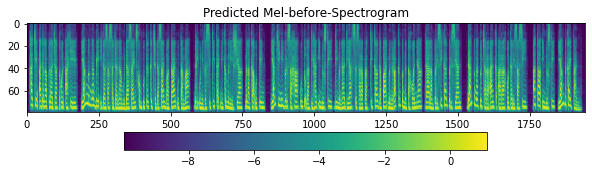

In [39]:
mel_outputs_ = np.reshape(o['mel_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

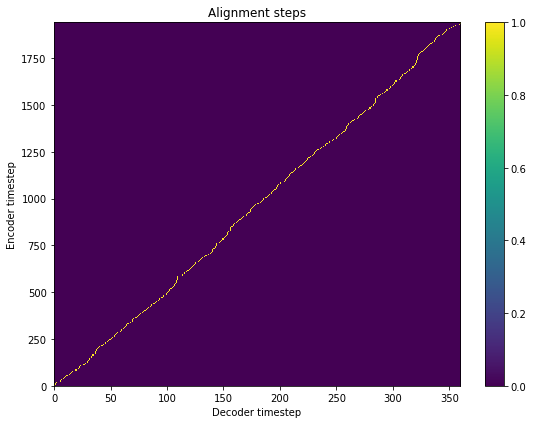

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o['alignment_histories'][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [41]:
from tensorflow.tools.graph_transforms import TransformGraph

In [42]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [43]:
pb = 'vits-yasmin-output-sdp/frozen_model.pb'

In [44]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

2022-08-05 14:59:41.265721: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying add_default_attributes
2022-08-05 14:59:41.428756: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying remove_nodes
2022-08-05 14:59:41.578570: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for mel_output
2022-08-05 14:59:41.578666: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for alignment_histories
2022-08-05 14:59:41.578713: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for y_hat
2022-08-05 14:59:41.805153: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for mel_output
2022-08-05 14:59:41.805437: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for alignment_histories
2022-08-05 14:59:41.805476: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for y_hat
2022-08-05 14:59:41.963709: I tensorflow/t

In [45]:
from malaya_boilerplate.huggingface import upload_dict

In [46]:
!tar -cvf vits-yasmin-output-sdp.tar vits-yasmin-output-sdp

vits-yasmin-output-sdp/
vits-yasmin-output-sdp/frozen_model.pb.quantized
vits-yasmin-output-sdp/frozen_model.pb
vits-yasmin-output-sdp/model.ckpt.meta
vits-yasmin-output-sdp/checkpoint
vits-yasmin-output-sdp/model.ckpt.index
vits-yasmin-output-sdp/model.ckpt.data-00000-of-00001


In [47]:
files_mapping = {'vits-yasmin-output-sdp.tar': 'vits-yasmin-output-sdp.tar'}
upload_dict(model = 'pretrained-vits', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: 57i3clhglZRx9bJ2dGdyq) - You already created this model repo


In [48]:
files_mapping = {'vits-yasmin-output-sdp/frozen_model.pb': 'model.pb'}
upload_dict(model = 'text-to-speech-vits-yasmin-sdp', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Dr8zZFziwXF8bop4Kxj8K) - You already created this model repo


In [49]:
files_mapping = {'vits-yasmin-output-sdp/frozen_model.pb.quantized': 'model.pb'}
upload_dict(model = 'text-to-speech-vits-yasmin-sdp-quantized', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: 67iTZ3N6-5k5vw-nv2PAd) - You already created this model repo
